# M5 Forecasting Challenge
<img src="https://images.ctfassets.net/osv85d77hkdf/7LsZ5bZzvGaG6iwYkoKEUc/84afe0bf84371542fe56e6d5f0b3377b/hero_telescope_01_2x.png" width="500" height="300" />

The goal of this notebook is to give competitors a quick overview of the 2020 M5 competition. After reading it you should have a good idea of the objective you are trying to solve, the data provided and the metrics you will be scored on.

Some tl;dr items to note:
- There are two parallel competitions: **Accuracy** and **Uncertainty**
    - The accuracy competition will use the metric: **Weighted Root Mean Squared Scaled Error** (RMSSE)
    - The uncertainty competition will use the metric: **Weighted Scaled Pinball Loss** (WSPL)
- We are tasked with forecasting hierarchical sales data from Wal-Mart.
- The data, covers stores in three US States (California, Texas, and Wisconsin) and includes item level, department, product categories, and store details.
- In addition, it has explanatory variables such as price, promotions, day of the week, and special events.

In [1]:
import pandas as pd
import numpy as np

#Visualization package
import matplotlib.pylab as plt
import seaborn as sns

#Combination
from itertools import cycle #Infinite iterator

#Other setting
pd.set_option('max_columns', 50)
plt.style.use('bmh')


#Import category10 color palette
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

# Data Files
- `calendar.csv` - Contains information about the dates on which the products are sold.
- `sales_train_validation.csv` - Contains the historical daily unit sales data per product and store [d_1 - d_1913]
- `sample_submission.csv` - The correct format for submissions. Reference the Evaluation tab for more info.
- `sell_prices.csv` - Contains information about the price of the products sold per store and date.

Not available yet:
- `sales_train_evaluation.csv` - Available one month before competition deadline. Will include sales [d_1 - d_1941]

In [19]:
ls ../Data

calendar.csv                sample_submission.csv
sales_train_validation.csv  sell_prices.csv


In [20]:
# Read in the data
INPUT_DIR = '../Data'
cal = pd.read_csv(f'{INPUT_DIR}/calendar.csv')
stv = pd.read_csv(f'{INPUT_DIR}/sales_train_validation.csv')
ss = pd.read_csv(f'{INPUT_DIR}/sample_submission.csv')
sellp = pd.read_csv(f'{INPUT_DIR}/sell_prices.csv')

# What exactly are we trying to predict?
We are trying for forecast sales for 28 forecast days. The sample submission has the following format:
- The columns represent 28 forecast days. We will fill these forecast days with our predictions.
- The rows each represent a specific item. This id tells us the item type, state, and store. We don't know what these items are exactly.

In [22]:
print(ss.shape)

(60980, 29)


In [21]:
ss.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


We are given historic sales data in the `sales_train_validation` dataset.
- rows exist in this dataset for days d_1 to d_1913. We are given the department, category, state, and store id of the item.
- d_1914 - d_1941 represents the `validation` rows which we will predict in stage 1
- d_1942 - d_1969 represents the `evaluation` rows which we will predict for the final competition standings.

In [ ]:
stv.head()

# Visualizing the data for a single item
- Lets take a random item that sell a lot and see how it's sales look across the training data.
- `FOODS_3_090_CA_3_validation` sells a lot
- Note there are days where it appears the item is unavailable and sales flatline

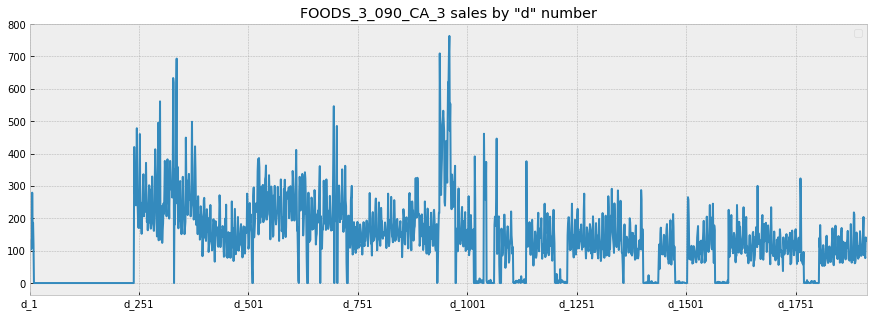

In [26]:
d_cols = [c for c in stv.columns if 'd_' in c] # sales data columns

# Below we are chaining the following steps in pandas:
# 1. Select the item.
# 2. Set the id as the index, Keep only sales data columns
# 3. Transform so it's a column
# 4. Plot the data

stv.loc[stv['id'] == 'FOODS_3_090_CA_3_validation'] \
    .set_index('id')[d_cols] \
    .T \
    .plot(figsize=(15, 5),
          title='FOODS_3_090_CA_3 sales by "d" number')
plt.legend('')
plt.show()

## Merging the data with real dates
- We are given a calendar with additional information about past and future dates.
- The calendar data can be merged with our days data
- From this we can find weekly and annual trends

In [28]:
cal.head(1)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0


In [27]:
# Calendar data looks like this (only showing columns we care about for now)
cal[['d','date','event_name_1','event_name_2',
     'event_type_1','event_type_2', 'snap_CA']].head()

,d,date,event_name_1,event_name_2,event_type_1,event_type_2,snap_CA
0,d_1,2011-01-29,NaN,NaN,NaN,NaN,0
1,d_2,2011-01-30,NaN,NaN,NaN,NaN,0
2,d_3,2011-01-31,NaN,NaN,NaN,NaN,0
3,d_4,2011-02-01,NaN,NaN,NaN,NaN,1
4,d_5,2011-02-02,NaN,NaN,NaN,NaN,1


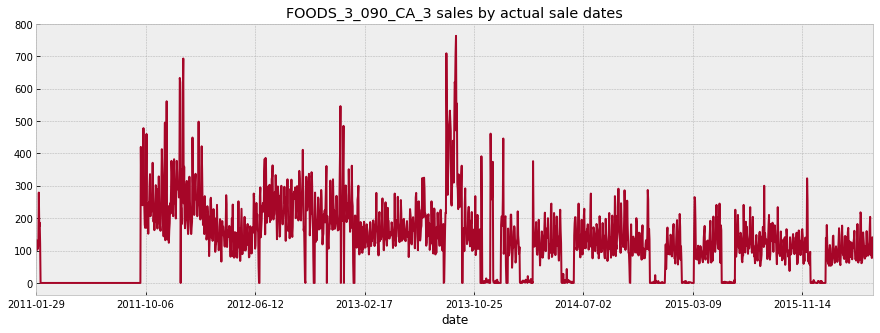

In [35]:
# Merge calendar on our items' data
example = stv.loc[stv['id'] == 'FOODS_3_090_CA_3_validation'][d_cols].T
example = example.rename(columns={8412:'FOODS_3_090_CA_3'}) # Name it correctly
example = example.reset_index().rename(columns={'index': 'd'}) # make the index "d"
example = example.merge(cal, how='left', validate='1:1')
example.set_index('date')['FOODS_3_090_CA_3'] \
    .plot(figsize=(15, 5),
          color=next(color_cycle),
          title='FOODS_3_090_CA_3 sales by actual sale dates')
plt.show()

# Sales broken down by time variables
- Now that we have our example item lets see how it sells by:
    - Day of the week
    - Month
    - Year

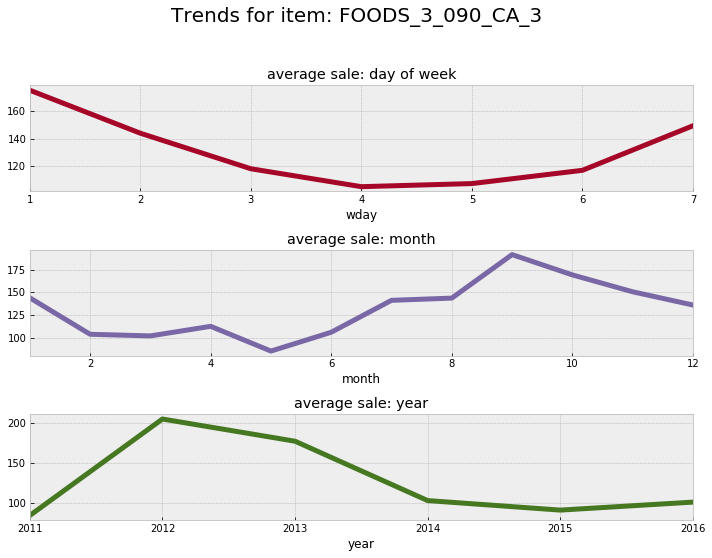

In [39]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 7))

example.groupby('wday').mean()['FOODS_3_090_CA_3'] \
    .plot(kind='line',
          title='average sale: day of week',
          lw=5,
          color=next(
              color_cycle),
          ax=ax1)

example.groupby('month').mean()['FOODS_3_090_CA_3'] \
    .plot(kind='line',
          title='average sale: month',
          lw=5,
          color=next(
               color_cycle),

          ax=ax2)
example.groupby('year').mean()['FOODS_3_090_CA_3'] \
    .plot(kind='line',
          lw=5,
          title='average sale: year',
          color=next(
              color_cycle),

          ax=ax3)

fig.suptitle('Trends for item: FOODS_3_090_CA_3',
             size=20,
             y=1.1)

#tight_layout automatically adjusts subplot params so that the subplot(s) fits in to the figure area
plt.tight_layout()
plt.show()

# Lets look at a lot of different items!
- Lets put it all together to plot 20 different items and their sales
- Some observations from these plots:
    - It is common to see an item unavailable for a period of time.
    - Some items only sell 1 or less in a day, making it very hard to predict.
    - Other items show spikes in their demand (super bowl sunday?) possibly the "events" provided to us could help with these.

In [60]:
twenty_examples = stv.sample(4, random_state=529) \
        .set_index('id')[d_cols] \
    .T \
    .merge(cal.set_index('d')['date'],
           left_index=True,
           right_index=True,
            validate='1:1') \
    .set_index('date')

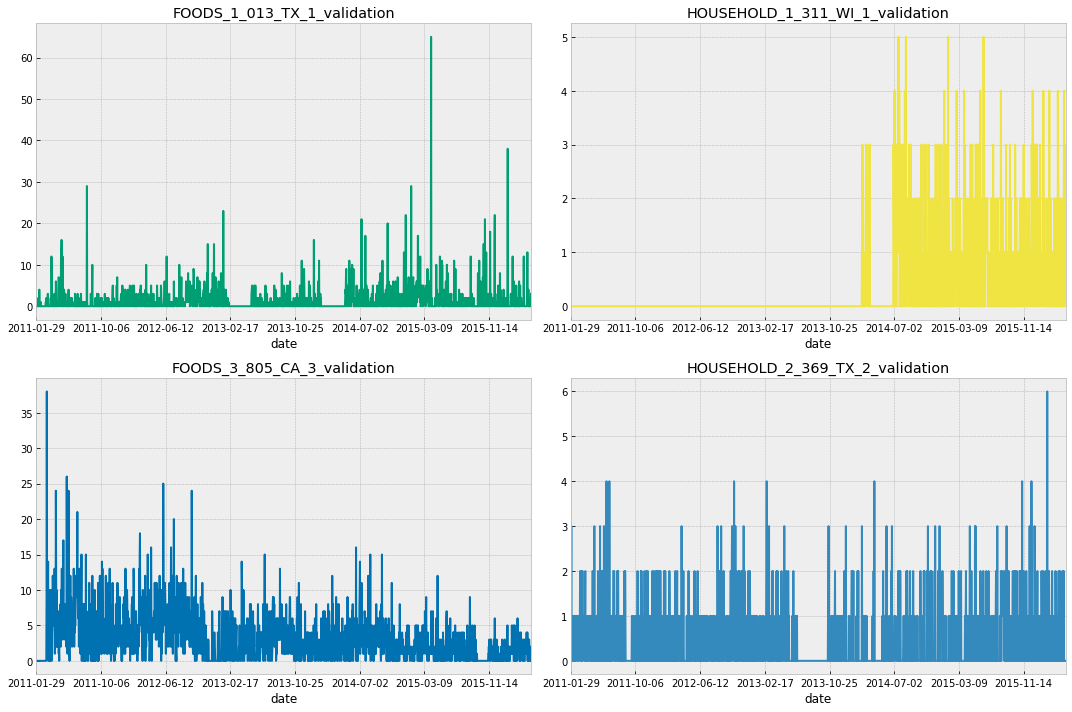

In [61]:
#Fast way to draw subplot
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()
ax_idx = 0
for item in twenty_examples.columns:
    twenty_examples[item].plot(title=item,
                              color=next(color_cycle),
                              ax=axs[ax_idx])
    ax_idx += 1
plt.tight_layout()
plt.show()

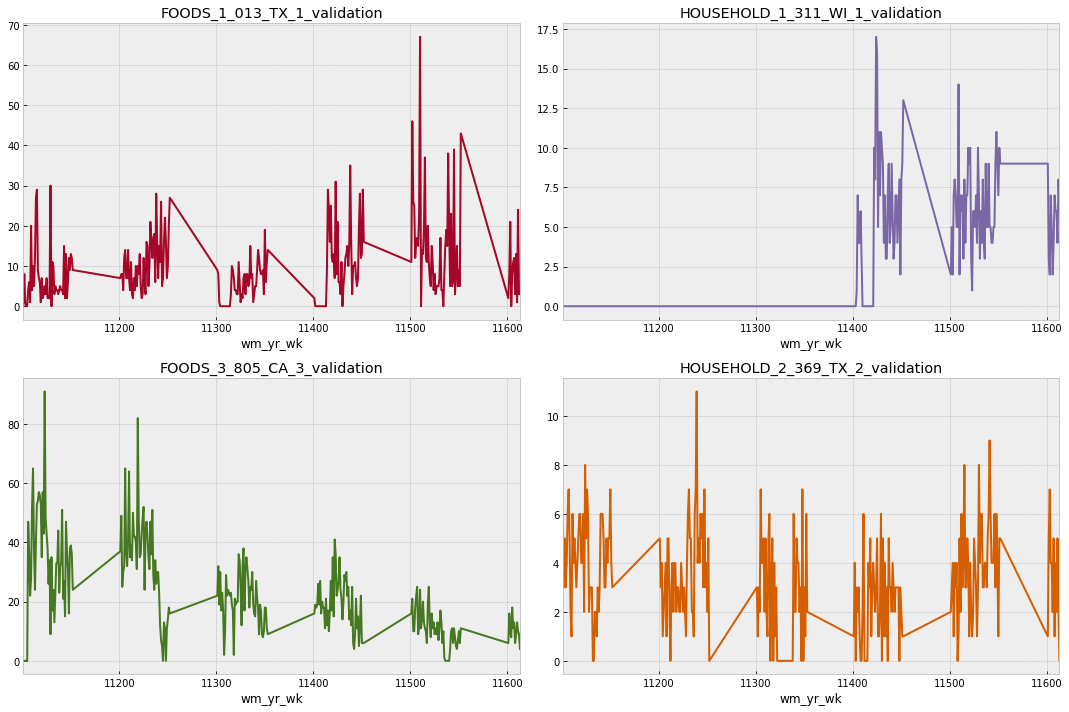

In [74]:
twenty_examples_by_month=twenty_examples
twenty_examples_by_month['wm_yr_wk']=cal.iloc[:1913].wm_yr_wk.values
twenty_examples_by_month=twenty_examples_by_month.groupby('wm_yr_wk').sum()

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()
ax_idx = 0
for item in twenty_examples_by_month.columns:
    twenty_examples_by_month[item].plot(title=item,
                              color=next(color_cycle),
                              ax=axs[ax_idx])
    ax_idx += 1
plt.tight_layout()
plt.show()

# Combined Sales over Time by Type
- We have several item types:
    - Hobbies
    - Household
    - Foods
- Lets plot the total demand over time for each type

In [76]:
stv['cat_id'].unique()

array(['HOBBIES', 'HOUSEHOLD', 'FOODS'], dtype=object)

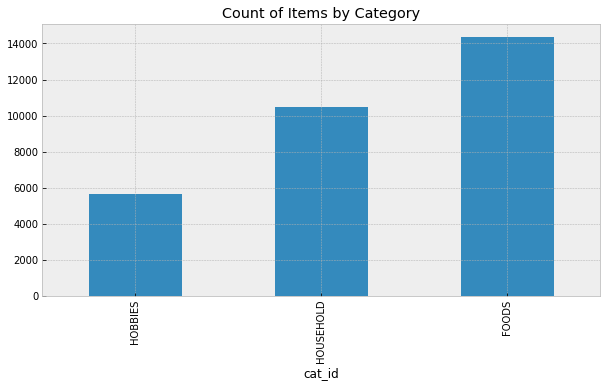

In [79]:
stv.groupby('cat_id').count()['id'] \
    .sort_values() \
    .plot(kind='bar', figsize=(10, 5), title='Count of Items by Category')
plt.show()

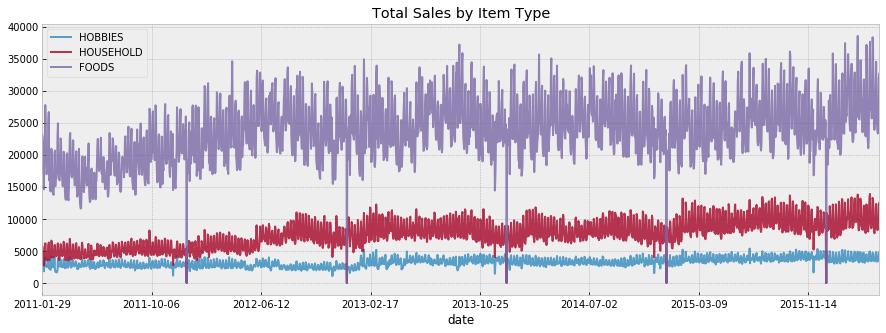

In [80]:
past_sales = stv.set_index('id')[d_cols] \
    .T \
    .merge(cal.set_index('d')['date'],
           left_index=True,
           right_index=True,
            validate='1:1') \
    .set_index('date')


for i in stv['cat_id'].unique():
    items_col = [c for c in past_sales.columns if i in c]
    past_sales[items_col] \
        .sum(axis=1) \
        .plot(figsize=(15, 5),
              alpha=0.8,
              title='Total Sales by Item Type')
plt.legend(stv['cat_id'].unique())
plt.show()

# Sales by Store
We are provided data for 10 unique stores. What are the total sales by stores?
- Note that some stores are more steady than others.
- CA_2 seems to have a big change occur in 2015

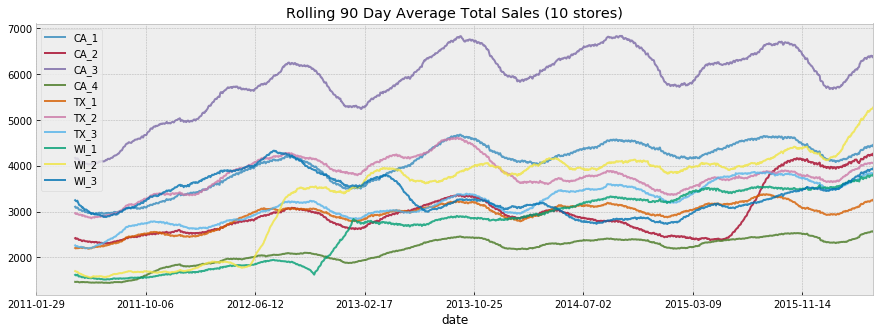

In [85]:
store_list = sellp['store_id'].unique()
for s in store_list:
    store_items = [c for c in past_sales.columns if s in c]
    past_sales[store_items] \
        .sum(axis=1) \
        .rolling(90).mean() \
        .plot(figsize=(15, 5),
              alpha=0.8,
              title='Rolling 90 Day Average Total Sales (10 stores)')
plt.legend(store_list)
plt.show()

Looking at the same data a different way, we can plot a rolling 7 day total demand count by store. Note clearly that some stores have abrupt changes in their demand, it could be that the store expanded or a new competitor was built near by. Either way this is imporant to note when creating predictive models about demand pattern. 

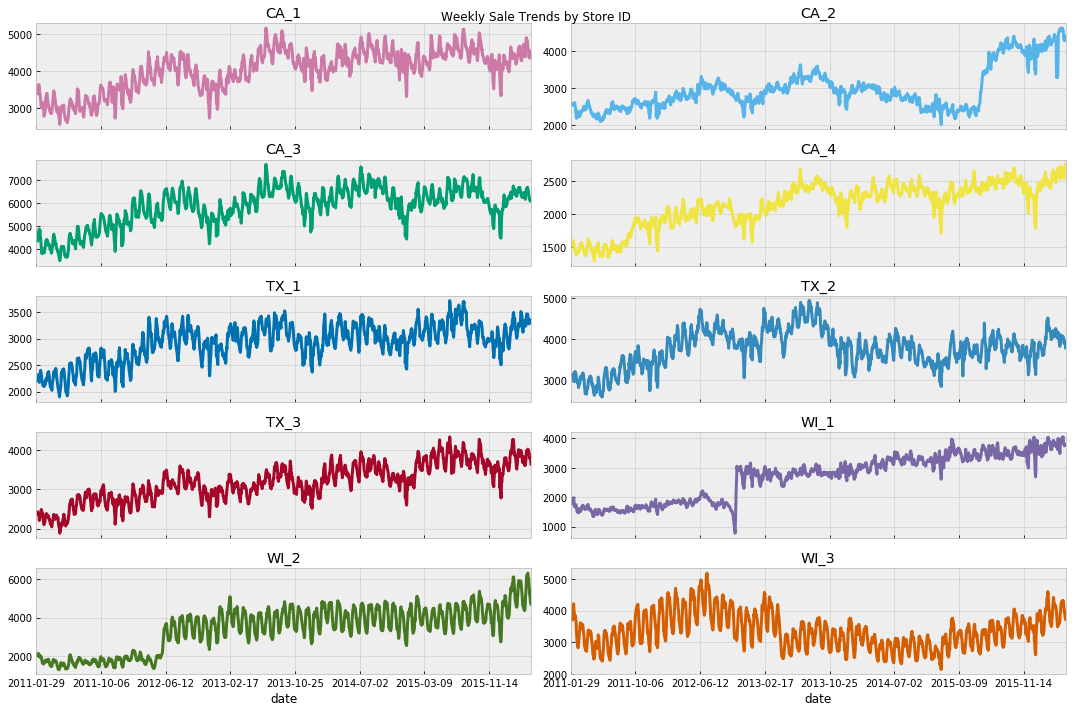

In [83]:
fig, axes = plt.subplots(5, 2, figsize=(15, 10), sharex=True)
axes = axes.flatten()
ax_idx = 0
for s in store_list:
    store_items = [c for c in past_sales.columns if s in c]
    past_sales[store_items] \
        .sum(axis=1) \
        .rolling(7).mean() \
        .plot(alpha=1,
              ax=axes[ax_idx],
              title=s,
              lw=3,
              color=next(color_cycle))
    ax_idx += 1
# plt.legend(store_list)
plt.suptitle('Weekly Sale Trends by Store ID')
plt.tight_layout()
plt.show()

# Sales Heatmap Calendar

In [90]:
# ----------------------------------------------------------------------------
# Author:  Nicolas P. Rougier
# License: BSD
# ----------------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from datetime import datetime
from dateutil.relativedelta import relativedelta


def calmap(ax, year, data):
    ax.tick_params('x', length=0, labelsize="medium", which='major')
    ax.tick_params('y', length=0, labelsize="x-small", which='major')

    # Month borders
    xticks, labels = [], []
    start = datetime(year,1,1).weekday()
    for month in range(1,13):
        first = datetime(year, month, 1)
        last = first + relativedelta(months=1, days=-1)

        y0 = first.weekday()
        y1 = last.weekday()
        x0 = (int(first.strftime("%j"))+start-1)//7
        x1 = (int(last.strftime("%j"))+start-1)//7

        P = [ (x0,   y0), (x0,    7),  (x1,   7),
              (x1,   y1+1), (x1+1,  y1+1), (x1+1, 0),
              (x0+1,  0), (x0+1,  y0) ]
        xticks.append(x0 +(x1-x0+1)/2)
        labels.append(first.strftime("%b"))
        poly = Polygon(P, edgecolor="black", facecolor="None",
                       linewidth=1, zorder=20, clip_on=False)
        ax.add_artist(poly)
    
    ax.set_xticks(xticks)
    ax.set_xticklabels(labels)
    ax.set_yticks(0.5 + np.arange(7))
    ax.set_yticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
    ax.set_title("{}".format(year), weight="semibold")
    
    # Clearing first and last day from the data
    valid = datetime(year, 1, 1).weekday()
    data[:valid,0] = np.nan
    valid = datetime(year, 12, 31).weekday()
    # data[:,x1+1:] = np.nan
    data[valid+1:,x1] = np.nan

    # Showing data
    ax.imshow(data, extent=[0,53,0,7], zorder=10, vmin=-1, vmax=1,
              cmap="RdYlBu_r", origin="lower", alpha=.75)

It appears that walmarts are closed on Chirstmas day. The highest demand day of all the data was on Sunday March 6th, 2016. What happened on this day you may ask... well the [Seventh Democratic presidential candidates debate hosted by CNN and held in Flint, Michigan](https://www.onthisday.com/date/2016/march/6)... I doubt that impacted sales though :D

In [91]:
print('The lowest sale date was:', past_sales.sum(axis=1).sort_values().index[0])
print('The highest sale date was:', past_sales.sum(axis=1).sort_values(ascending=False).index[0])

The lowest sale date was: 2012-12-25
The highest sale date was: 2016-03-06


In [96]:
# from sklearn.preprocessing import StandardScaler
# sscale = StandardScaler()
# past_sales.index = pd.to_datetime(past_sales.index)
# for i in stv['cat_id'].unique():
#     fig, axes = plt.subplots(3, 1, figsize=(20, 8))
#     items_col = [c for c in past_sales.columns if i in c]
#     sales2013 = past_sales.loc[past_sales.index.isin(pd.date_range('31-Dec-2012',
#                                                                    periods=371))][items_col].mean(axis=1)
#     vals = np.hstack(sscale.fit_transform(sales2013.values.reshape(-1, 1)))
#     calmap(axes[0], 2013, vals.reshape(53,7).T)
#     sales2014 = past_sales.loc[past_sales.index.isin(pd.date_range('30-Dec-2013',
#                                                                    periods=371))][items_col].mean(axis=1)
#     vals = np.hstack(sscale.fit_transform(sales2014.values.reshape(-1, 1)))
#     calmap(axes[1], 2014, vals.reshape(53,7).T)
#     sales2015 = past_sales.loc[past_sales.index.isin(pd.date_range('29-Dec-2014',
#                                                                    periods=371))][items_col].mean(axis=1)
#     vals = np.hstack(sscale.fit_transform(sales2015.values.reshape(-1, 1)))
#     calmap(axes[2], 2015, vals.reshape(53,7).T)
#     plt.suptitle(i, fontsize=15, x=0.3, y=0.98)
#     plt.tight_layout()
#     plt.show()

In [101]:
items_col = [c for c in past_sales.columns if i in c]
sales2015 = past_sales.loc[past_sales.index.isin(pd.date_range('29-Dec-2014',
                                                         periods=371))][items_col].mean(axis=1)
vals = np.hstack(sscale.fit_transform(sales2015.values.reshape(-1, 1))) #normalize: (x-mu)/std

In [105]:
sales2015

0.0

In [100]:
from sklearn.preprocessing import StandardScaler
sscale = StandardScaler()
past_sales.index = pd.to_datetime(past_sales.index)
for i in stv['cat_id'].unique():
    plt.figure(figsize=(20, 8))
    items_col = [c for c in past_sales.columns if i in c]
    sales2015 = past_sales.loc[past_sales.index.isin(pd.date_range('29-Dec-2014',
                                                         periods=371))][items_col].mean(axis=1)
    vals = np.hstack(sscale.fit_transform(sales2015.values.reshape(-1, 1)))
    calmap( 2015, vals.reshape(53,7).T)
    plt.suptitle(i, fontsize=15, x=0.3, y=0.98)
    plt.tight_layout()
    plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'tick_params'

<Figure size 1440x576 with 0 Axes>

Some interesting things to note from these heatmaps:
- Food tends to have lower number of purchases as the month goes on. Could this be because people get their paychecks early in the month?
- Household and Hobby items sell much less in January - after the Holiday season is over.
- Cleary weekends are more popular shopping days regardless of the item category.

# Sale Prices
We are given historical sale prices of each item. Lets take a look at our example item from before.
- It looks to me like the price of this item is growing.
- Different stores have different selling prices.

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
stores = []
for store, d in sellp.query('item_id == "FOODS_3_090"').groupby('store_id'):
    d.plot(x='wm_yr_wk',
          y='sell_price',
          style='.',
          color=next(color_cycle),
          figsize=(15, 5),
          title='FOODS_3_090 sale price over time',
         ax=ax,
          legend=store)
    stores.append(store)
    plt.legend()
plt.legend(stores)
plt.show()

In [ ]:
sellp['Category'] = sellp['item_id'].str.split('_', expand=True)[0]
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
i = 0
for cat, d in sellp.groupby('Category'):
    ax = d['sell_price'].apply(np.log1p) \
        .plot(kind='hist',
                         bins=20,
                         title=f'Distribution of {cat} prices',
                         ax=axs[i],
                                         color=next(color_cycle))
    ax.set_xlabel('Log(price)')
    i += 1
plt.tight_layout()

# A simple submission
- Submit the average value from the past 30 days

In [ ]:
thirty_day_avg_map = stv.set_index('id')[d_cols[-30:]].mean(axis=1).to_dict()
fcols = [f for f in ss.columns if 'F' in f]
for f in fcols:
    ss[f] = ss['id'].map(thirty_day_avg_map).fillna(0)
    
ss.to_csv('submission.csv', index=False)

## TODO
- Simple prediction based on historical average sale by day of week
- Facebook prophet model
- lgbm/xgb model based on day features